# Lecture des données géospatiales


Pour relier les données de rendement de production annuelle d'avoine aux données météorologiques annuelles, nous devons utiliser des données géospatiales et la librairie geopandas.

Les données géospatiales des régions ("district") peuvent être téléchargées.  Il existe plusieurs formats de données géospatiales.  Nous utiliserons les shape files (.shp).

https://geohub.lio.gov.on.ca/datasets/municipal-boundary-upper-tier-and-district/explore?location=46.487638%2C-81.744527%2C4.73&showTable=true




<img src='https://drive.google.com/uc?export=view&id=1S3lIKmZdOe0-PchH9-ITBmdvbn0zPEO3' width='450px'>

Nous allons placer les stations météorologiques dans ces régions.



### Installation et chargement des librairies python

Nous devons d'abord charger (et possiblement installer) les librairies nécessaires.  

Voici une description de certaines des librairies utilisées.

- `os` permet d'utiliser des fonctions liées aux fichiers sur disque et au système d'exploitation.
- `collections`  fournit des structures de données supplémentaires et des alternatives aux types de données intégrés (built-in) 
- `matplotlib` et `seaborn` pour générer des graphiques
- `numpy` pour des opérations d'algèbres linéaires et mathématiques
- `pandas` pour faciliter la manipulation et la structure des données (parfois lent pour les gros jeux de données)
- `geopandas` étend les fonctionnalités de la bibliothèque Pandas pour la manipulation et l'analyse des données géospatiales.
- `gdown` pour télécharger des fichiers (volumineux) de Google Drive.

In [1]:
#!pip install gdown
#!pip install geopandas
import os
import gdown
import pandas as pd
import numpy as np
import geopandas as gpd
import urllib.request 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#!pip install ydata_profiling
#from ydata_profiling import ProfileReport
colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"] # palette IVADO
%matplotlib inline

/Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/.venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#%cd /content/drive/My Drive/Notebook_Dataset

### Lecture du shapefile avec geopandas

Le fichier .shp contient les coordonnées de polygones représentant les contours des régions administratives ontariennes.   Il est possible de représenter graphiquement les régions sous forme de carte.  Le fichier récupéré contient aussi le nom des régions. 

 Nous allons donc nous servir :
 
* du nom des régions pour faire le chevauchement avec les données de rendement
* les coordonnées géographiques des stations météorologiques pour faire le lien avec les données météorologiques

In [3]:
# Pour récupérer les données de Google Drive
file_ids = [("MUNIC_BND_UPPER_AND_DIST.shp", '1yaTkZXl2CVMGEsAvn3dkS4ezrwbpYZ7R'),
            ("MUNIC_BND_UPPER_AND_DIST.shx", '1mGn7yo7mLjMauxwzXa_Xf2pjth0m6_OR'),
            ("MUNIC_BND_UPPER_AND_DIST.prj", '1UemI8VZciW9eitgGIqewcn0Vzjp8xHdN'),
            ("MUNIC_BND_UPPER_AND_DIST.dbf", '1iajak-GjTI7xZvPSRqZrO0EoyHAowQNv')]

url = "https://drive.google.com/uc?export=view&id=%s"

datadir = 'tmp/LIO-2022-10-19'
if not os.path.exists(datadir):
    os.makedirs(datadir)

In [4]:
# On utilise gdown pour télécharger tous les fichiers
for file_name, file_id in file_ids:
    url_file = url%file_id
    print(file_name, url_file)
    output = os.path.join(datadir, file_name)
    gdown.download(url_file, output, quiet=False)

MUNIC_BND_UPPER_AND_DIST.shp https://drive.google.com/uc?export=view&id=1yaTkZXl2CVMGEsAvn3dkS4ezrwbpYZ7R


Downloading...
From (uriginal): https://drive.google.com/uc?export=view&id=1yaTkZXl2CVMGEsAvn3dkS4ezrwbpYZ7R
From (redirected): https://drive.google.com/uc?export=view&id=1yaTkZXl2CVMGEsAvn3dkS4ezrwbpYZ7R&confirm=t&uuid=63c6043a-6224-4fc3-8cab-86e1c0a63ca9
To: /Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/notebooks/Nettoyage/tmp/LIO-2022-10-19/MUNIC_BND_UPPER_AND_DIST.shp
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108M/108M [00:02<00:00, 50.7MB/s]


MUNIC_BND_UPPER_AND_DIST.shx https://drive.google.com/uc?export=view&id=1mGn7yo7mLjMauxwzXa_Xf2pjth0m6_OR


Downloading...
From: https://drive.google.com/uc?export=view&id=1mGn7yo7mLjMauxwzXa_Xf2pjth0m6_OR
To: /Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/notebooks/Nettoyage/tmp/LIO-2022-10-19/MUNIC_BND_UPPER_AND_DIST.shx
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 884/884 [00:00<00:00, 1.53MB/s]


MUNIC_BND_UPPER_AND_DIST.prj https://drive.google.com/uc?export=view&id=1UemI8VZciW9eitgGIqewcn0Vzjp8xHdN


Downloading...
From: https://drive.google.com/uc?export=view&id=1UemI8VZciW9eitgGIqewcn0Vzjp8xHdN
To: /Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/notebooks/Nettoyage/tmp/LIO-2022-10-19/MUNIC_BND_UPPER_AND_DIST.prj
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 397kB/s]


MUNIC_BND_UPPER_AND_DIST.dbf https://drive.google.com/uc?export=view&id=1iajak-GjTI7xZvPSRqZrO0EoyHAowQNv


Downloading...
From: https://drive.google.com/uc?export=view&id=1iajak-GjTI7xZvPSRqZrO0EoyHAowQNv
To: /Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/notebooks/Nettoyage/tmp/LIO-2022-10-19/MUNIC_BND_UPPER_AND_DIST.dbf
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60.6k/60.6k [00:00<00:00, 4.51MB/s]


In [5]:
# Ou on utilise gdown pour télécharger tous les fichiers volumineux qui ne peuvent être téléchargés
# par urlretrieve.  Il y a une limite sur la taille imposée par google drive (le scan du fichier n'est pas possible).
#for file_name, file_id in file_ids:
#    url_file = url%file_id
#    print(file_name, url_file)
#    output = os.path.join(datadir, file_name)
#    dest, resp = urllib.request.urlretrieve(url_file, output)
#    header = dict(resp.__dict__['_headers'])
#    disposition = header.get('Content-Disposition', None)
#    length = header.get('Content-Length', None)
#    if length is None:
#        gdown.download(url_file, output, quiet=False)

In [6]:
!ls tmp/LIO-2022-10-19

MUNIC_BND_UPPER_AND_DIST.dbf MUNIC_BND_UPPER_AND_DIST.shp
MUNIC_BND_UPPER_AND_DIST.prj MUNIC_BND_UPPER_AND_DIST.shx


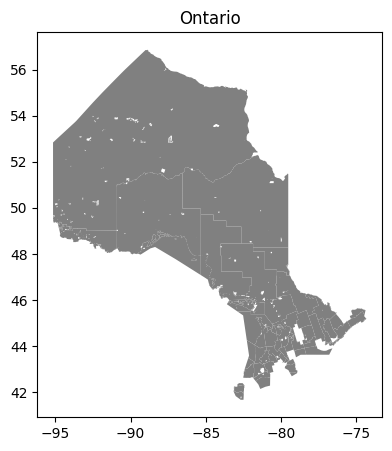

In [7]:
# Ceci prend environ 30-60 secondes à exécuter sur un macbook pro 2019
#data_path = "../data/raw/"
#data_path = 'tmp' # path absolu 
ontario_shp = "tmp/LIO-2022-10-19/MUNIC_BND_UPPER_AND_DIST.shp"
ontario = gpd.read_file(ontario_shp)
ontario.plot(figsize=(10, 5), color='grey')
plt.title("Ontario")
plt.show()

In [8]:
ontario.head(3)

OGF_ID                  SUBTYPE  STYPE_NUM                  MUN_NAME  \
0  67907495  Upper Tier Municipality         70  COUNTY OF NORTHUMBERLAND   
1  67907531  Upper Tier Municipality         70       COUNTY OF MIDDLESEX   
2  67907554  Upper Tier Municipality         70       COUNTY OF FRONTENAC   

   MUNID MAH_CODE  EXTENT_T ASSESS_C  NAME_PREF      NAME_SHORT GUNT_DES  \
0  14000    61074   Islands     1400  COUNTY OF  NORTHUMBERLAND     2561   
1  39000    59000  Mainland     3900  COUNTY OF       MIDDLESEX     2561   
2  10000    46000     Water     1000  COUNTY OF       FRONTENAC     2561   

       GEO_UPD_DT        EFF_DATE  \
0  20220909134431  20220909103055   
1  20220909134432  20220909103101   
2  20220909134434  20220909103107   

                                            geometry  
0  MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ...  
1  MULTIPOLYGON (((-81.43651 42.79026, -81.43651 ...  
2  POLYGON ((-76.16528 44.28195, -76.16429 44.240...

In [9]:
ontario.columns

Index(['OGF_ID', 'SUBTYPE', 'STYPE_NUM', 'MUN_NAME', 'MUNID', 'MAH_CODE',
       'EXTENT_T', 'ASSESS_C', 'NAME_PREF', 'NAME_SHORT', 'GUNT_DES',
       'GEO_UPD_DT', 'EFF_DATE', 'geometry'],
      dtype='object')

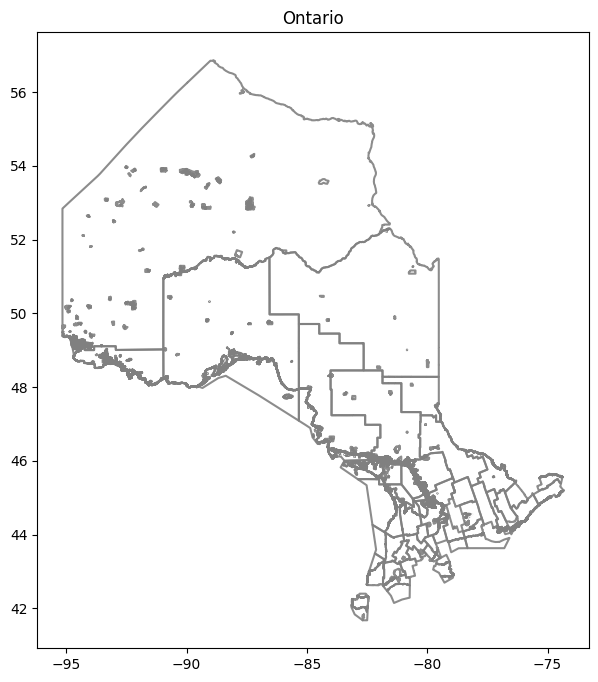

In [10]:
ontario.boundary.plot(color='grey', alpha=0.9, figsize=(13, 8))
plt.title("Ontario")
plt.show()

## Lecture données de rendement de la production d'avoine

In [11]:
id = "1qWzM2lfJlsB4VJRy0o-Hm8sfr8W2aROG"  
url = "https://drive.google.com/uc?export=view&id=%s" % id
oats = pd.read_csv(url, index_col=0)


# Provenant du Notebook 1_Nettoyage_Donnees_Avoine.ipynb
#filename = 'rendement_avoine_v1.csv'
#oats = pd.read_csv(filename, index_col=0)

In [12]:
oats.head()

Region   Ensemencee    Recoltee  Rendement  \
0              Brant     0.000000    0.000000   0.000000   
1       Chatham-Kent     0.000000    0.000000   0.000000   
2              Elgin     0.000000    0.000000   0.000000   
3              Essex     0.000000    0.000000   0.000000   
4  Haldimand-Norfolk  1025.801292  865.261503  56.554159   

   Production_boisseaux  Production_tonnes    Onglet  Annee  
0              0.000000           0.000000  oats2022   2022  
1              0.000000           0.000000  oats2022   2022  
2              0.000000           0.000000  oats2022   2022  
3              0.000000           0.000000  oats2022   2022  
4             48.934137           0.993852  oats2022   2022

## Lecture données météorologiques

In [13]:
file_id = '1d5DzDVtOtXtf02KF7Nk05XyveMxYfuzi'
url = "https://drive.google.com/uc?export=view&id=%s" % file_id
weather = pd.read_csv(url)

# Provenant du Notebook 2_Nettoyage_Donnees_Temperature.ipynb
#weather = pd.read_csv('weather_yearly_v1.csv')

In [14]:
weather.head()

Unnamed: 0  LOCAL_YEAR     STATION_NAME          x          y  LATITUDE  \
0           0        2004         ALBERTON -80.050000  43.183333    43.183   
1           4        2004  ALLISTON NELSON -79.872247  44.151397    44.151   
2           5        2004      AMHERSTBURG -83.094463  42.103358    42.103   
3           6        2004         APPLETON -76.112805  45.185840    45.186   
4           8        2004   ATIKOKAN (AUT) -91.628056  48.761111    48.761   

   LONGITUDE CLIMATE_IDENTIFIER  TOTAL_PRECIPITATION  DAYS_WITH_VALID_PRECIP  \
0    -80.050            6150060                803.3                   366.0   
1    -79.872            6110218                860.2                   366.0   
2    -83.094            6130257               1053.2                   366.0   
3    -76.113            6100285                833.6                   366.0   
4    -91.628            6020LPQ                658.8                   343.0   

   DAYS_WITH_PRECIP_GE_1MM  TOTAL_SNOWFALL  DAYS_WITH_VALID_SNOWFALL  \
0                    118.0            94.0                     366.0   
1                    144.0           186.0                     366.0   
2                    126.0            83.8                     366.0   
3                    113.0           118.8                     366.0   
4                    103.0             4.6                      13.0   

   DAYS_WITH_VALID_SUNSHINE  MEAN_TEMPERATURE  MAX_TEMPERATURE  \
0                       0.0          8.925161             32.0   
1                       0.0          8.432473             32.0   
2                       0.0         10.800269             32.0   
3                       0.0          7.232634             30.0   
4                       0.0          3.959023             30.7   

   MIN_TEMPERATURE  
0            -27.0  
1            -30.0  
2            -22.0  
3            -32.0  
4            -39.5

## Chevauchement dans les données

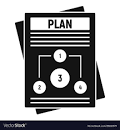


<span style='font-size:20px'>
Il faut intégrer les deux jeux de données, soit les données météorologiques et les données de rendement de la production d'avoine.

Comment faire ? 

1-  Associer les données de rendement de production d'avoine aux données géograghiques des régions ontariennes par nom de région.

2-  Associer les stations météorologiques aux régions ontariennes en utilisant les coordonnées géographiques des régions et des stations.

3 - Aggréger les valeurs collectées par des stations météo se trouvant dans une même région.

</span>

### Étape 1 - Données de rendement d'avoine + données géographiques

<br>

<span style='font-size:20px'>
Avant de procéder avec la première étape, nous devons vérifier que les noms de régions dans les données de rendement et dans les données géographiques sont les mêmes.
Ils doivent être identiques car ils serviront de clés pour fusionner les deux jeux de données.
</span>

In [15]:
ontario.loc[:,'Region'] = [c.title() for c in ontario.NAME_SHORT]
oats.loc[:,'Region'] = [c.title() for c in oats.Region]
ontario_regions = sorted(ontario.Region.unique())
oats_regions = sorted(oats.Region.unique().tolist())

regions_common = set(ontario_regions) & set(oats_regions)
diff_regions = list(set(ontario_regions).difference(set(oats_regions)))

In [16]:
print(F'Nombre de régions communes: {len(regions_common)}')
print(F'Nombre de régions dans le fichier de régions: {len(ontario_regions)}')
print(F'Nombre de régions dans le fichier de rendement: {len(oats_regions)}')

print()
print(F"Régions dans le shapefile ne se trouvant pas dans le fichier de rendement : {len(diff_regions)}/{len(oats_regions)}")
print(', '.join(diff_regions))

diff_regions = list(set(oats_regions).difference(set(ontario_regions)))
print(F"Régions dans le fichier de rendement ne se trouvant pas dans le shapefile : {len(diff_regions)}/{len(ontario_regions)}")
print(', '.join(diff_regions))

Nombre de régions communes: 40
Nombre de régions dans le fichier de régions: 40
Nombre de régions dans le fichier de rendement: 50

Régions dans le shapefile ne se trouvant pas dans le fichier de rendement : 0/50

Régions dans le fichier de rendement ne se trouvant pas dans le shapefile : 10/40
Hamilton, Grand Sudbury, Prince Edward, Prescott And Russell United, Chatham-Kent, Leeds And Grenville United, Brant, Kawartha Lakes, Haldimand-Norfolk, Ottawa


In [17]:
ontario_oats = ontario.merge(oats, on='Region', how='left')
ontario_oats.columns

Index(['OGF_ID', 'SUBTYPE', 'STYPE_NUM', 'MUN_NAME', 'MUNID', 'MAH_CODE',
       'EXTENT_T', 'ASSESS_C', 'NAME_PREF', 'NAME_SHORT', 'GUNT_DES',
       'GEO_UPD_DT', 'EFF_DATE', 'geometry', 'Region', 'Ensemencee',
       'Recoltee', 'Rendement', 'Production_boisseaux', 'Production_tonnes',
       'Onglet', 'Annee'],
      dtype='object')

In [18]:
ontario_oats.head(4)

OGF_ID                  SUBTYPE  STYPE_NUM                  MUN_NAME  \
0  67907495  Upper Tier Municipality         70  COUNTY OF NORTHUMBERLAND   
1  67907495  Upper Tier Municipality         70  COUNTY OF NORTHUMBERLAND   
2  67907495  Upper Tier Municipality         70  COUNTY OF NORTHUMBERLAND   
3  67907495  Upper Tier Municipality         70  COUNTY OF NORTHUMBERLAND   

   MUNID MAH_CODE EXTENT_T ASSESS_C  NAME_PREF      NAME_SHORT  ...  \
0  14000    61074  Islands     1400  COUNTY OF  NORTHUMBERLAND  ...   
1  14000    61074  Islands     1400  COUNTY OF  NORTHUMBERLAND  ...   
2  14000    61074  Islands     1400  COUNTY OF  NORTHUMBERLAND  ...   
3  14000    61074  Islands     1400  COUNTY OF  NORTHUMBERLAND  ...   

         EFF_DATE                                           geometry  \
0  20220909103055  MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ...   
1  20220909103055  MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ...   
2  20220909103055  MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ...   
3  20220909103055  MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ...   

           Region   Ensemencee     Recoltee  Rendement  Production_boisseaux  \
0  Northumberland   394.917011   349.432698  61.443588             21.470399   
1  Northumberland    15.994022    10.774613  31.024343              0.334275   
2  Northumberland  3010.000000  2410.000000  24.543568             59.150000   
3  Northumberland  1640.000000  1410.000000  41.851032             59.009956   

   Production_tonnes    Onglet  Annee  
0           0.436064  oats2022   2022  
1           0.006789  oats2021   2021  
2           0.912217  oats2020   2020  
3           0.910058  oats2019   2019  

[4 rows x 22 columns]

Regardons de quoi avait l'air le rendement d'avoine dans les différentes régions de l'Ontario pour une année donnée.  


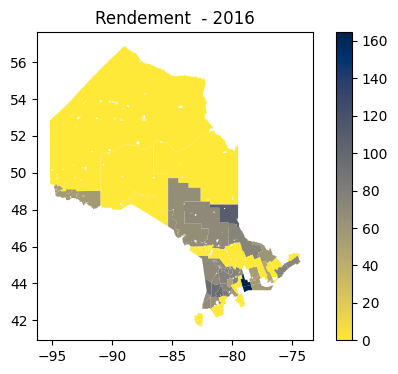

In [19]:
# comptez 30-40 secondes (ou plus)
def plot_map(df, year, var, figsize=(6, 4)):
    df.loc[df.Annee==year,:].plot(
        column=var,
        cmap='cividis_r',
        legend=True,
        figsize=figsize,
        missing_kwds={
            "color": "lightgrey",
            "label": "Missing values",
        },
    )
    plt.title(F"{var.title()}  - {year}")
    plt.show()
    
plot_map(ontario_oats, 2016, 'Rendement')

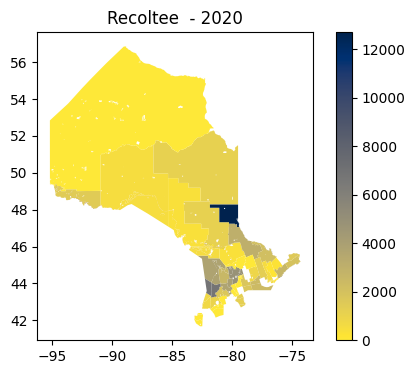

In [20]:
plot_map(ontario_oats, 2020, 'Recoltee')

En 2020, la plupart des acres récoltées se trouvaient au sud ouest.

### Étapes 2  -  Données de rendement + données géographiques + Données météo

In [21]:
ontario_oats.head()

OGF_ID                  SUBTYPE  STYPE_NUM                  MUN_NAME  \
0  67907495  Upper Tier Municipality         70  COUNTY OF NORTHUMBERLAND   
1  67907495  Upper Tier Municipality         70  COUNTY OF NORTHUMBERLAND   
2  67907495  Upper Tier Municipality         70  COUNTY OF NORTHUMBERLAND   
3  67907495  Upper Tier Municipality         70  COUNTY OF NORTHUMBERLAND   
4  67907495  Upper Tier Municipality         70  COUNTY OF NORTHUMBERLAND   

   MUNID MAH_CODE EXTENT_T ASSESS_C  NAME_PREF      NAME_SHORT  ...  \
0  14000    61074  Islands     1400  COUNTY OF  NORTHUMBERLAND  ...   
1  14000    61074  Islands     1400  COUNTY OF  NORTHUMBERLAND  ...   
2  14000    61074  Islands     1400  COUNTY OF  NORTHUMBERLAND  ...   
3  14000    61074  Islands     1400  COUNTY OF  NORTHUMBERLAND  ...   
4  14000    61074  Islands     1400  COUNTY OF  NORTHUMBERLAND  ...   

         EFF_DATE                                           geometry  \
0  20220909103055  MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ...   
1  20220909103055  MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ...   
2  20220909103055  MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ...   
3  20220909103055  MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ...   
4  20220909103055  MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ...   

           Region   Ensemencee     Recoltee  Rendement  Production_boisseaux  \
0  Northumberland   394.917011   349.432698  61.443588             21.470399   
1  Northumberland    15.994022    10.774613  31.024343              0.334275   
2  Northumberland  3010.000000  2410.000000  24.543568             59.150000   
3  Northumberland  1640.000000  1410.000000  41.851032             59.009956   
4  Northumberland  1100.000000   860.000000  65.104651             55.990000   

   Production_tonnes    Onglet  Annee  
0           0.436064  oats2022   2022  
1           0.006789  oats2021   2021  
2           0.912217  oats2020   2020  
3           0.910058  oats2019   2019  
4           0.863484  oats2018   2018  

[5 rows x 22 columns]

In [22]:
# (comptez 20 secondes)
# Intégration des données de météo aux données de régions ontariennes
geometry = gpd.points_from_xy(weather.x, weather.y)
weather_gdf = gpd.GeoDataFrame(weather, geometry=geometry)
joined = gpd.sjoin(weather_gdf, ontario_oats, how="right", predicate="within")
joined = joined.loc[joined.STATION_NAME.notnull(),:]
joined.LOCAL_YEAR = joined.LOCAL_YEAR.astype(int)
my_data = joined.loc[joined.LOCAL_YEAR==joined.Annee, :]

/var/folders/jc/f6v43psn1vs2wsxdh3svtxfh0000gn/T/ipykernel_45938/2785669019.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined = gpd.sjoin(weather_gdf, ontario_oats, how="right", predicate="within")


In [23]:
my_data.head(3)

index_left  Unnamed: 0  LOCAL_YEAR          STATION_NAME          x  \
19      2163.0      3427.0        2022  STRATHROY-MULLIFARRY -81.642802   
20      2047.0      3263.0        2021  STRATHROY-MULLIFARRY -81.642802   
21      1924.0      3095.0        2020  STRATHROY-MULLIFARRY -81.642802   

            y  LATITUDE  LONGITUDE CLIMATE_IDENTIFIER  TOTAL_PRECIPITATION  \
19  42.980562    42.981    -81.643            6148122                746.6   
20  42.980562    42.981    -81.643            6148122               1028.4   
21  42.980562    42.981    -81.643            6148122                966.6   

    ...        EFF_DATE                                           geometry  \
19  ...  20220909103101  MULTIPOLYGON (((-81.43651 42.79026, -81.43651 ...   
20  ...  20220909103101  MULTIPOLYGON (((-81.43651 42.79026, -81.43651 ...   
21  ...  20220909103101  MULTIPOLYGON (((-81.43651 42.79026, -81.43651 ...   

       Region   Ensemencee     Recoltee  Rendement  Production_boisseaux  \
19  Middlesex  2226.739391  1878.250579  51.455739             96.646771   
20  Middlesex   294.489662   153.313771  90.484517             13.872522   
21  Middlesex  1200.000000  1000.000000  64.700000             64.700000   

    Production_tonnes    Onglet Annee  
19           1.962896  oats2022  2022  
20           0.281751  oats2021  2021  
21           0.997810  oats2020  2020  

[3 rows x 40 columns]

In [24]:
my_data.head(2)

index_left  Unnamed: 0  LOCAL_YEAR          STATION_NAME          x  \
19      2163.0      3427.0        2022  STRATHROY-MULLIFARRY -81.642802   
20      2047.0      3263.0        2021  STRATHROY-MULLIFARRY -81.642802   

            y  LATITUDE  LONGITUDE CLIMATE_IDENTIFIER  TOTAL_PRECIPITATION  \
19  42.980562    42.981    -81.643            6148122                746.6   
20  42.980562    42.981    -81.643            6148122               1028.4   

    ...        EFF_DATE                                           geometry  \
19  ...  20220909103101  MULTIPOLYGON (((-81.43651 42.79026, -81.43651 ...   
20  ...  20220909103101  MULTIPOLYGON (((-81.43651 42.79026, -81.43651 ...   

       Region   Ensemencee     Recoltee  Rendement  Production_boisseaux  \
19  Middlesex  2226.739391  1878.250579  51.455739             96.646771   
20  Middlesex   294.489662   153.313771  90.484517             13.872522   

    Production_tonnes    Onglet Annee  
19           1.962896  oats2022  2022  
20           0.281751  oats2021  2021  

[2 rows x 40 columns]

In [25]:
def plot_map_improved(dat, year, var, with_labels=True, figsize=(10, 8)):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.axis('off')
    ax.set_title('', fontdict={'fontsize': '5', 'fontweight' : '1'})
    color = 'Oranges'
    vmin = 0
    vmax = dat[var].max()*1.05

    mx = dat.loc[dat['LOCAL_YEAR']==year,:].drop_duplicates()
    mx.plot(var, cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(10,8),
          legend=True,
          legend_kwds={"label": f"{var} in {year}", "orientation": "horizontal"},
          missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Missing values",
    },)
    if with_labels:
        tmp = mx.loc[:,['x', 'y', 'Region', 'STATION_NAME']].drop_duplicates()
        for idx, row in tmp.iterrows():
            #plt.annotate(text=F"{row['Region']}-{row['STATION_NAME']}", xy=(row['x'], row['y']),
            plt.annotate(text='x', xy=(row['x'], row['y']),
                    horizontalalignment='center', fontsize='small', color='black', wrap=True)
    plt.title(F'{year} - {var}')
    plt.show()

Plusieurs stations météorologiques font la collecte de données pour une même région géographique.
Elles sont parfois rapprochées et parfois plus éloignées.

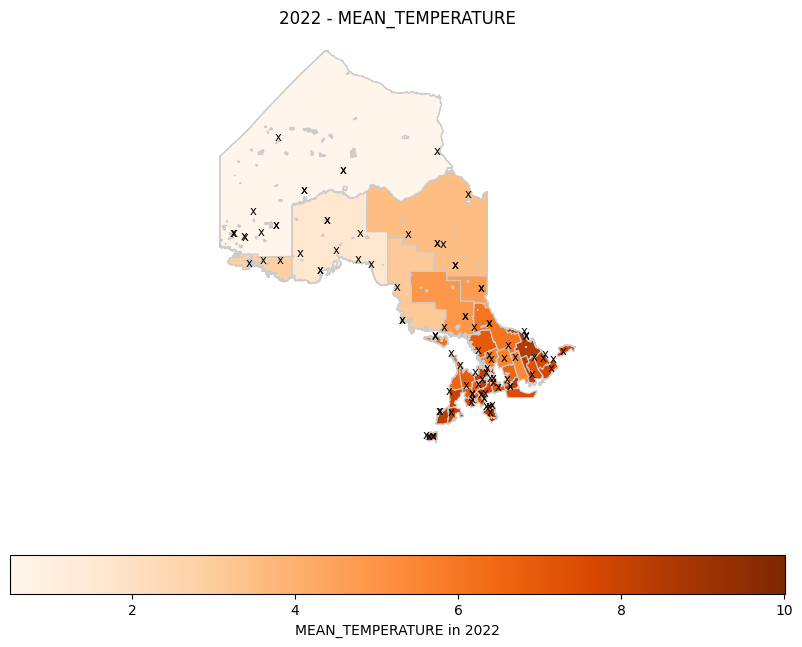

In [26]:
plot_map_improved(my_data, 2022, 'MEAN_TEMPERATURE', figsize=(10, 8))

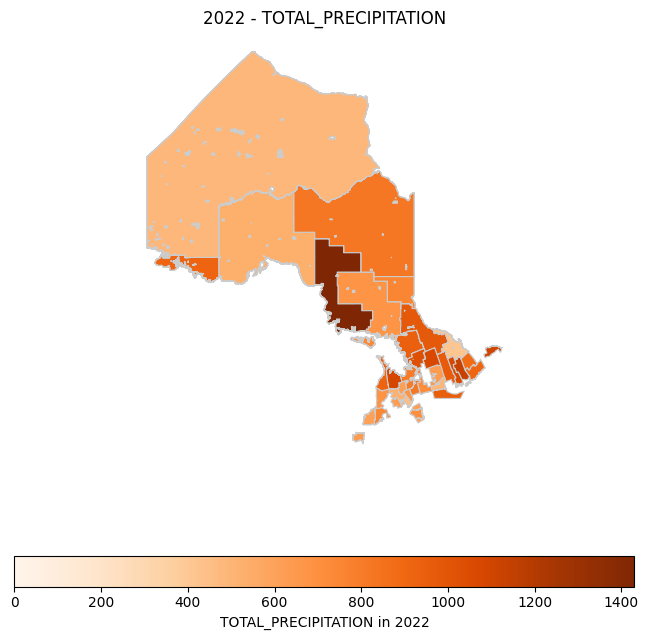

In [27]:
plot_map_improved(my_data, 2022, 'TOTAL_PRECIPITATION', with_labels=False, figsize=(8,8))

In [28]:
my_data.loc[my_data.TOTAL_PRECIPITATION==0,:]


index_left  Unnamed: 0  LOCAL_YEAR  STATION_NAME          x          y  \
245       2133.0      3388.0        2022  OAKVILLE TWN -79.690000  43.512500   
1716       129.0       194.0        2004    WAWA (AUT) -84.783333  47.966667   

      LATITUDE  LONGITUDE CLIMATE_IDENTIFIER  TOTAL_PRECIPITATION  ...  \
245     43.513    -79.690            6155750                  0.0  ...   
1716    47.967    -84.783            6059408                  0.0  ...   

            EFF_DATE                                           geometry  \
245   20220909103056  POLYGON ((-79.78375 43.56694, -79.78257 43.566...   
1716  20220909103119  MULTIPOLYGON (((-84.87996 49.70919, -84.68708 ...   

      Region   Ensemencee     Recoltee  Rendement  Production_boisseaux  \
245   Halton    37.426612    30.934565  26.034128              0.805354   
1716  Algoma  1700.000000  1100.000000  64.197899             70.620000   

      Production_tonnes    Onglet Annee  
245            0.016357  oats2022  2022  
1716           1.089109   ots2004  2004  

[2 rows x 40 columns]

Certaines régions n'auraient reçu aucune précipitation en 2022 (valeur de 0). 
D'après vous, est-ce possible ?

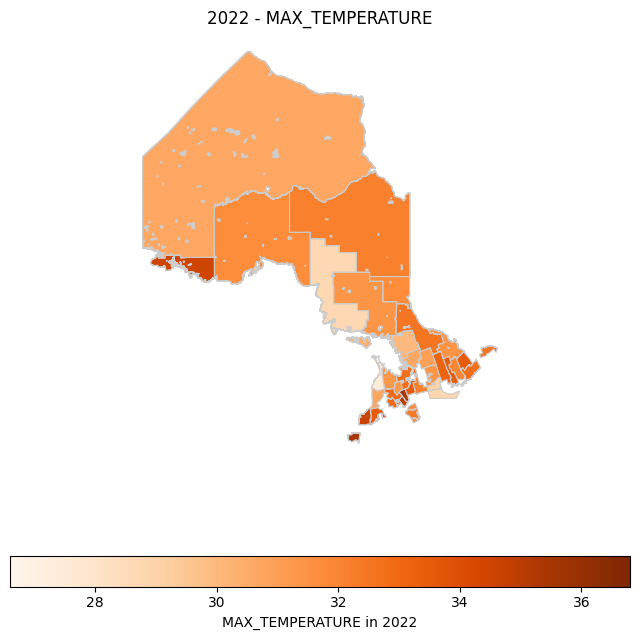

In [29]:
plot_map_improved(my_data, 2022, 'MAX_TEMPERATURE', with_labels=False, figsize=(8,8))

Certaines régions n'ont pas de données pour la température maximale enregistrée en 2015.

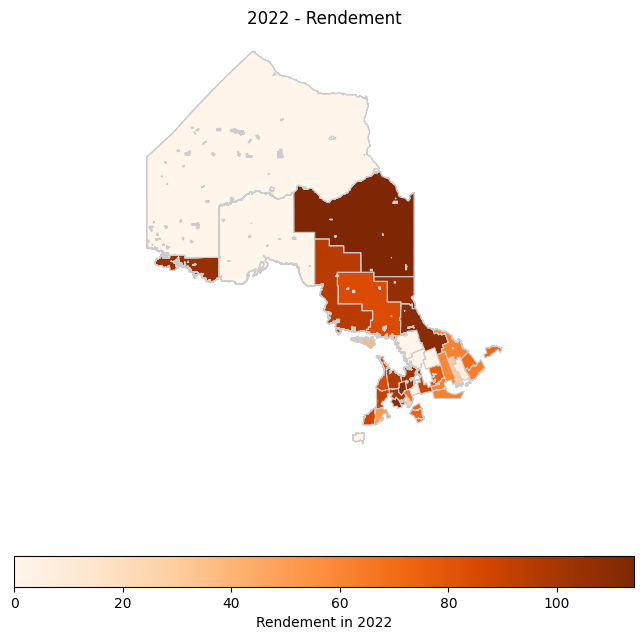

In [30]:
plot_map_improved(my_data, 2022, 'Rendement', with_labels=False, figsize=(8,8))

## Explorons un peu la matrice fusionnée 

Notre matrice de données contient maintenant les données de rendement et de météo.  Quelles informations pouvons-nous en tirer ?


Est-ce que nos données sont propres ou doivent-elles être nettoyées ?  Qu'en pensez-vous ?
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

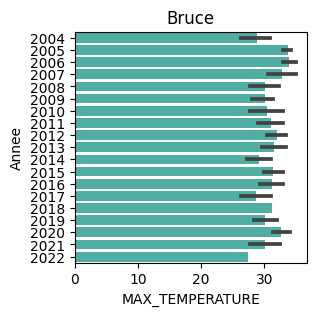

In [31]:
region = 'Bruce'
_ = plt.figure(figsize=(3,3))
mx = my_data.loc[my_data.Region==region,:]
sns.barplot(mx, x='MAX_TEMPERATURE', y='Annee', 
            orient='h', color=colors[0])
plt.title(region)
plt.show()

In [32]:
# Regardons les stations dont le nom contient 'BEATRICE' dans la région de Muskoka.  
# Les stations ne sont pas très éloignées. 
my_data.loc[my_data.STATION_NAME.str.contains("BEATRICE"), :].sort_values('LOCAL_YEAR').head(4)

index_left  Unnamed: 0  LOCAL_YEAR      STATION_NAME          x  \
1433        10.0        18.0        2004        BEATRICE 2 -79.400000   
1431       239.0       437.0        2006  BEATRICE CLIMATE -79.402778   
1430       341.0       653.0        2007  BEATRICE CLIMATE -79.402778   
1430       340.0       652.0        2007        BEATRICE 2 -79.400000   

              y  LATITUDE  LONGITUDE CLIMATE_IDENTIFIER  TOTAL_PRECIPITATION  \
1433  45.133333    45.133    -79.400            6110606               1077.4   
1431  45.140278    45.140    -79.403            6110607               1071.4   
1430  45.140278    45.140    -79.403            6110607                989.2   
1430  45.133333    45.133    -79.400            6110606               1075.8   

      ...        EFF_DATE                                           geometry  \
1433  ...  20220909103057  MULTIPOLYGON (((-78.91925 45.52441, -78.91159 ...   
1431  ...  20220909103057  MULTIPOLYGON (((-78.91925 45.52441, -78.91159 ...   
1430  ...  20220909103057  MULTIPOLYGON (((-78.91925 45.52441, -78.91159 ...   
1430  ...  20220909103057  MULTIPOLYGON (((-78.91925 45.52441, -78.91159 ...   

       Region  Ensemencee  Recoltee  Rendement  Production_boisseaux  \
1433  Muskoka       300.0     200.0  65.059396                 13.01   
1431  Muskoka       229.0     200.0  47.000000                  9.40   
1430  Muskoka       100.0     100.0  43.000000                  4.30   
1430  Muskoka       100.0     100.0  43.000000                  4.30   

      Production_tonnes    Onglet Annee  
1433           0.200642   ots2004  2004  
1431           0.144968  oats2006  2006  
1430           0.066315  oats2007  2007  
1430           0.066315  oats2007  2007  

[4 rows x 40 columns]

### Observations    
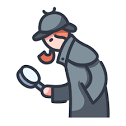


* Il y a plusieurs stations pour une même région

* Il y a plusieurs mesures par année par région, car il y a plusieurs stations météo par région



Nous ne voulons qu'une seule valeur par région pour les différentes caractéristiques météorologiques. 
Nous allons donc faire la moyenne des données des différentes stations pour une région donnée pour chaque année.

In [33]:
cols = ['LATITUDE', 'LONGITUDE','MEAN_TEMPERATURE', 'MIN_TEMPERATURE',
        'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'DAYS_WITH_VALID_PRECIP',
        'DAYS_WITH_PRECIP_GE_1MM', 'TOTAL_SNOWFALL', 'DAYS_WITH_VALID_SNOWFALL',
        'DAYS_WITH_VALID_SUNSHINE', 'Ensemencee','Recoltee', 'Rendement', 
        'Production_boisseaux', 'Production_tonnes','Annee']

t = pd.DataFrame()
for region in my_data.Region.unique():
    tmp = my_data.loc[my_data.Region==region,:]
    for year in tmp.LOCAL_YEAR.unique():
        tmp2 = tmp.loc[tmp.LOCAL_YEAR==year,:]
        tmp2 = tmp2.loc[:, cols]
        tmp2 = tmp2.mean(0)  # Nous faisons la moyenne pour chaque caractéristique
        tmp2['Region'] = region
        tmp2['Annee'] = year
        t = pd.concat([t, tmp2.T], axis=1)
t = t.T

In [34]:
tmp = t.copy()
tmp = tmp.drop_duplicates()
tmp.Annee = tmp.Annee.astype(int)
tmp.sort_values(['Rendement', 'Annee'], inplace=True)

Regardons les données aggrégées

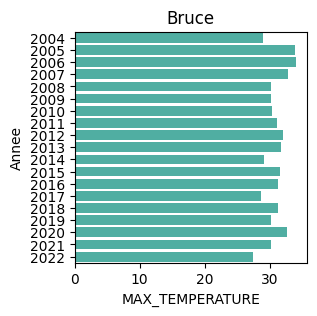

In [35]:
region = 'Bruce'
_ = plt.figure(figsize=(3,3))
sns.barplot(tmp.loc[tmp.Region==region,:],  x='MAX_TEMPERATURE', y='Annee', orient='h', color=colors[0])
plt.title(region)
plt.show()

La moyenne de température maximale pour les stations de la région de Bruce est légèrement moins élevée en 2022.  Est-ce que la collecte de données était complètes ?

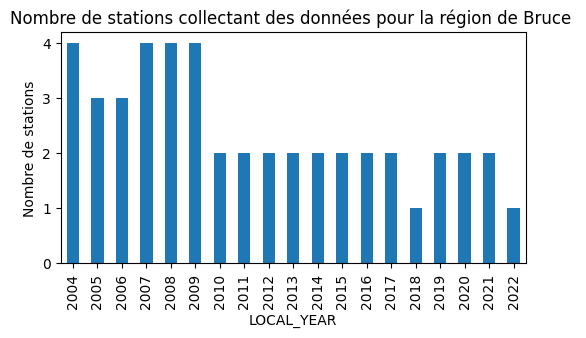

In [36]:
_ = plt.figure(figsize=(6,3))
mx.groupby('LOCAL_YEAR').count()['MAX_TEMPERATURE'].plot(kind='bar')
plt.title(F'Nombre de stations collectant des données pour la région de {region} ')
plt.ylabel('Nombre de stations')
plt.show()

Continuons l'exploration en générant des graphiques ciblés.  
Tous ne sont pas informatifs.  

Lesquels sont pertinents et véhiculent de l'information sur le jeu de données ?

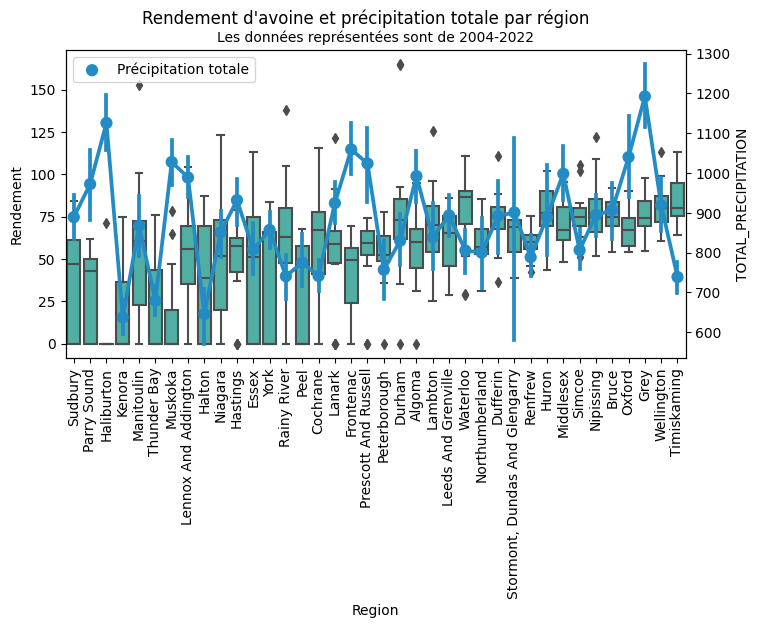

In [37]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(tmp, y='Rendement', x='Region', color=colors[0], ax=ax,)
plt.xticks(rotation=90)
ax2 = plt.twinx()
sns.pointplot(tmp,  y='TOTAL_PRECIPITATION', x='Region', color=colors[1], ax=ax2, label='Précipitation totale')
plt.xticks(rotation=90)
plt.suptitle("Rendement d'avoine et précipitation totale par région")
plt.title("Les données représentées sont de 2004-2022", fontsize=10)
plt.legend()
plt.show()

[]

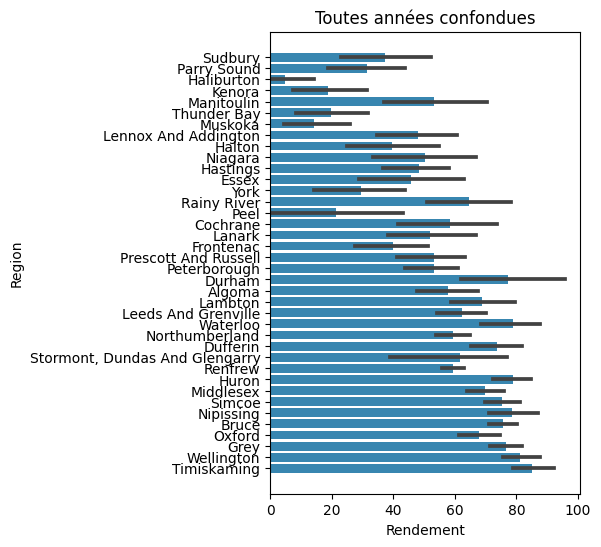

In [38]:
fig, ax = plt.subplots(figsize=(4,6))
sns.barplot(tmp,  x='Rendement', y='Region', orient='h', color=colors[1])#palette='Oranges')
plt.title('Toutes années confondues')
plt.plot()

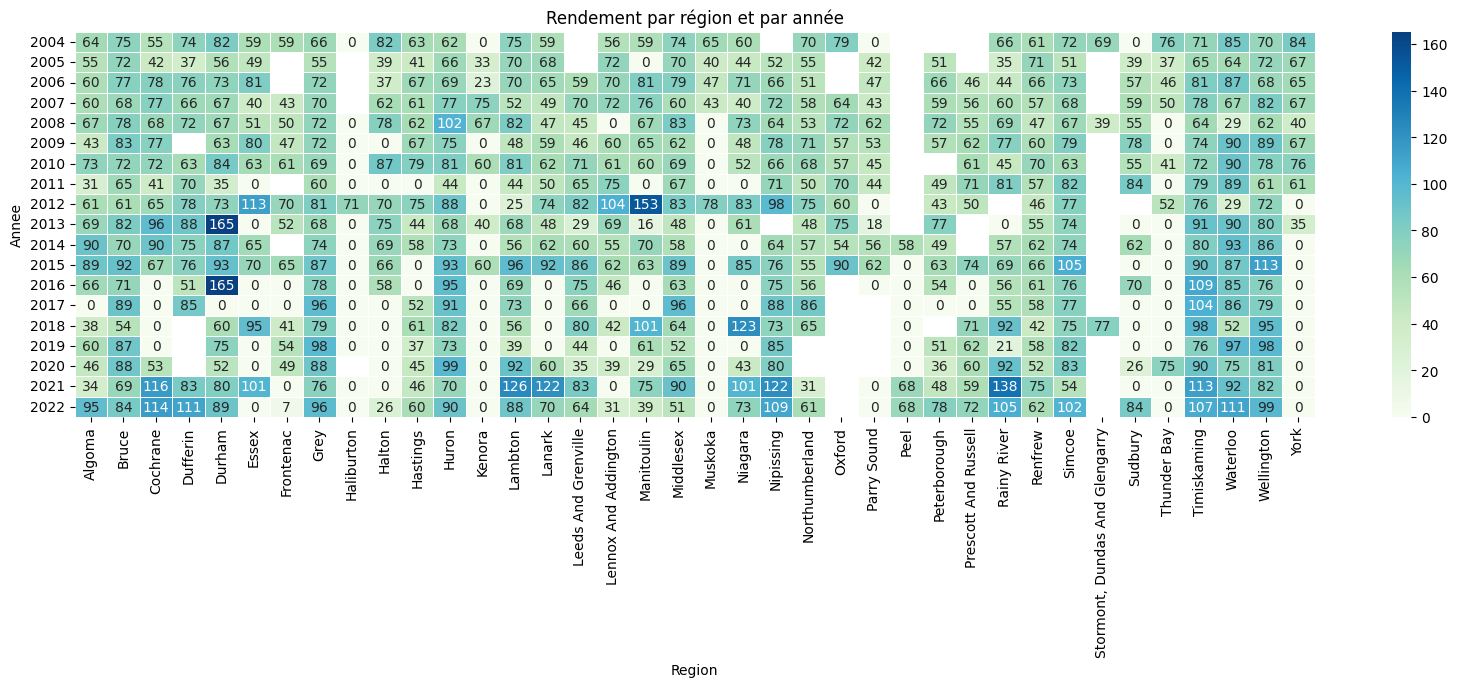

In [39]:
fig, ax = plt.subplots(figsize=(20,5))
mx = tmp.pivot(index="Annee", columns="Region", values="Rendement").astype('float')
sns.heatmap(mx, annot=True, ax=ax, fmt=".0f", cmap='GnBu', linewidths=.5)
plt.title('Rendement par région et par année')
plt.show()

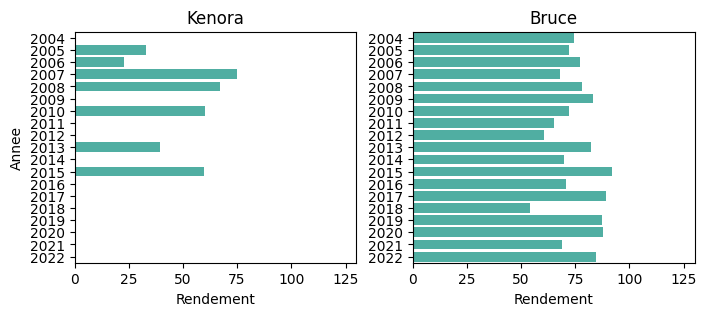

In [40]:
_= plt.figure(figsize=(8,3))
plt.subplot(121)
region = 'Kenora'
sns.barplot(tmp.loc[tmp.Region==region,:],  x='Rendement', y='Annee', orient='h', color=colors[0])
plt.title(region)
plt.xlim(0, 130)

plt.subplot(122)
region = 'Bruce'
sns.barplot(tmp.loc[tmp.Region==region,:],  x='Rendement', y='Annee', orient='h', color=colors[0])
plt.xlim(0, 130)
plt.ylabel('')
plt.title(region)
plt.show()

### Réflexions - Remises en question 

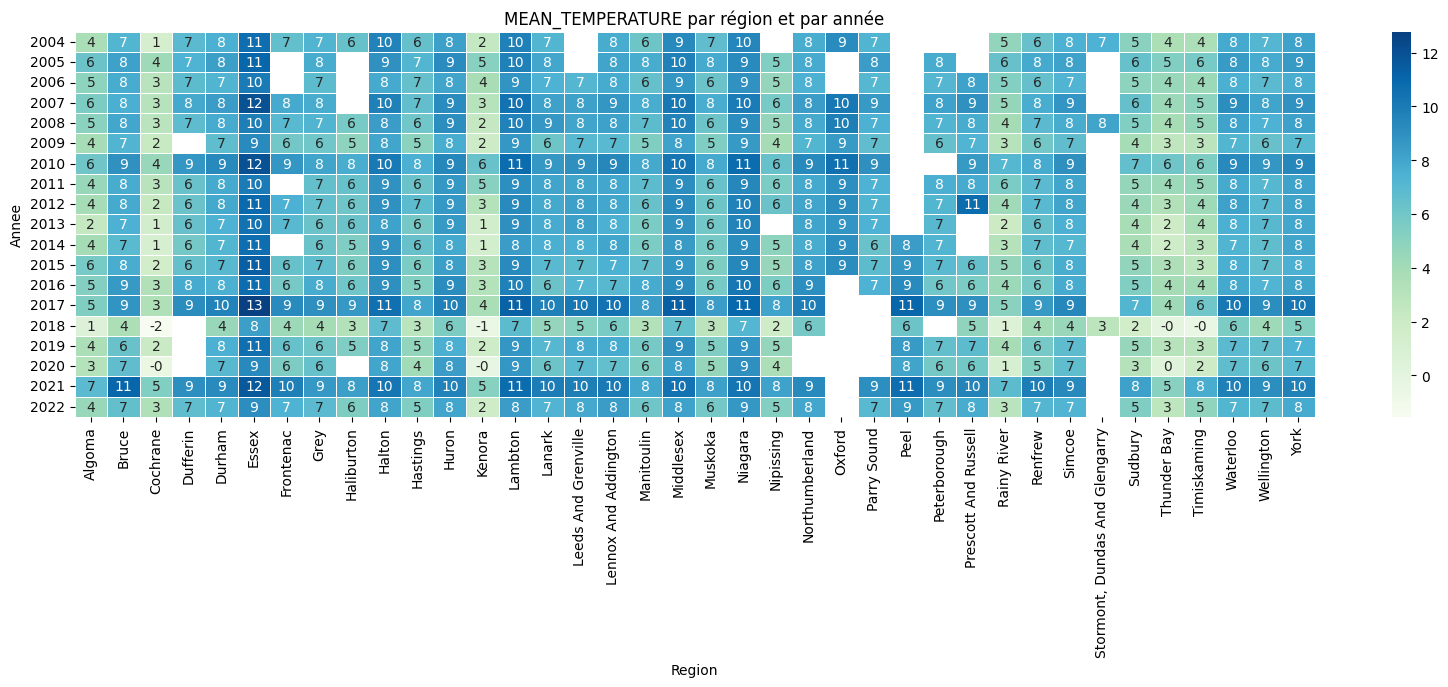

In [41]:
fig, ax = plt.subplots(figsize=(20,5))
mx = tmp.pivot(index="Annee", columns="Region", values="MEAN_TEMPERATURE").astype('float')
sns.heatmap(mx, annot=True, ax=ax, fmt=".0f", cmap='GnBu', linewidths=.5)
plt.title('MEAN_TEMPERATURE par région et par année')
plt.show()

Ici la variable `MEAN_TEMPERATURE` n'est pas vraiment la valeur moyenne rencontrée durant l'année.

C'est plutôt la médiane des températures moyennes mensuelles que nous avions calculée plus tôt.  

Est-ce représentatif d'après vous ?  

Devrions-nous renommer la variable ou appliquer une autre transformation ?

In [42]:
tmp.to_csv('dataset_v1.csv')